# Agents & Tools

There are multiple, often competing, and usually vague definition of what an LLM agent is. In general, however, it describes LLM-powered systems that can accomplish complex tasks by chaining multiple LLMs together and/or adding addtional tools (such as a calculator or external APIs) into the chain. The use of tools is important, as it allows LLMs to excel at tasks they are naturally bad at - for example, a model will suddenly be a lot better at math if it does not probabilistically guess the result of an equation, but can access Python to type in the numbers and calculate the result. A lot of the "intelligence" showcased in LLM-applications such as ChatGPT, such as turning data into graphs, comes from such agents and their use of tools. 

There are multiple frameworks to using agents and tools, including solutions by openAI. We will, however, use [_LangChain_](https://python.langchain.com/docs/introduction/) and [_LangGraph_](https://langchain-ai.github.io/langgraph/), as they are more flexible and provide compatibility for open source solutions such as Ollama. Additionally, this framework comes with a number of powerful functionalities which we will not cover in-depth here, such as [message handling](https://python.langchain.com/docs/concepts/chat_history/) for prolonged chat applications, forcing chat models to return [structured output](https://python.langchain.com/docs/concepts/structured_outputs/), addding [Human-in-the-loop](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/) functionality, or pre-built [ReAct agents](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent).

## Supervisors

One application of agentic systems are supervisors. They are an additional LLM that "supervise" other models, either by delegating tasks to different parts of the system (e.g. different tools) or by judging the output of an LLM.

In order to set up such a system, we will use _LangGraph_ to set up a graph - a network - of different models. The communication both between user input and between the models will - once again - be handled in the message format we already know. However, as we will see, using messages to communicate between models will require a slightly different use of messages. Specifically, we will need to make the models communicate by adding messages to previous messages. We will do so by utilizing a `MessagesState`.

Among other things, this allows us to leverage the strengths of different models, or have a more powerful model judge the output of a weaker model, saving compute by passing less input to the powerful model and have it judge only edge cases.

In [ ]:
# we'll start with our classification function, employing ollama 
# However, this time we set up the model beforehand and the only input the function gets will be a MessagesState

from langgraph.graph import MessagesState 
from langgraph.graph import add_messages  
from langchain_ollama import ChatOllama
import re

classifier_llm = ChatOllama(model = "llama3.2",
                        temperature=0.0,
                        num_ctx = 20000, # this sets the size of the context window!
                        # you can add additional parameters here
                        )


def classify_text(state: MessagesState):

  # construct input
  messages = [
    # system prompt, this will contain all instructions for the model
    {"role": "system", "content": system_message}] + state["messages"]
    # we're appending the MessagesState to the system message

  response = classifier_llm.invoke(messages)

  # we're adding the response to the state and return it
  state["messages"] = add_messages(state["messages"],response) 
  return state

In [ ]:
# we're setting up our system prompt as before

# the CAP labels
cap_labels = {
    "1": "Issues related to general domestic macroeconomic policy; Interest Rates; Unemployment Rate; Monetary Policy; National Budget; Tax Code; Industrial Policy; Price Control; other macroeconomics subtopics",
    "2": "Issues related generally to civil rights and minority rights; Minority Discrimination; Gender Discrimination; Age Discrimination; Handicap Discrimination; Voting Rights; Freedom of Speech; Right to Privacy; Anti-Government; other civil rights subtopics",
    "3": "Issues related generally to health care, including appropriations for general health care government agencies; Health Care Reform; Insurance; Drug Industry; Medical Facilities; Insurance Providers; Medical Liability; Manpower; Disease Prevention; Infants and Children; Mental Health; Long-term Care; Drug Coverage and Cost; Tobacco Abuse; Drug and Alcohol Abuse; health care research and development; issues related to other health care topics",
    "4": "Issues related to general agriculture policy, including appropriations for general agriculture government agencies; agricultural foreign trade; Subsidies to Farmers; Food Inspection & Safety; Food Marketing & Promotion; Animal and Crop Disease; Fisheries & Fishing; agricultural research and development; issues related to other agricultural subtopics",
    "5": "Issues generally related to labor, employment, and pensions, including appropriations for government agencies regulating labor policy; Worker Safety; Employment Training; Employee Benefits; Labor Unions; Fair Labor Standards; Youth Employment; Migrant and Seasonal workers; Issues related to other labor policy",
    "6": "Issues related to General education policy, including appropriations for government agencies regulating education policy; Higher education, student loans and education finance, and the regulation of colleges and universities; Elementary & Secondary education; Underprivileged students; Vocational education; Special education and education for the physically or mentally handicapped; Education Excellence; research and development in education; issues related to other subtopics in education policy",
    "7": "Issues related to General environmental policy, including appropriations for government agencies regulating environmental policy; Drinking Water; Waste Disposal; Hazardous Waste; Air Pollution; Recycling; Indoor Hazards; Species & Forest; Land and Water Conservation; research and development in environmental technology, not including alternative energy; issues related to other environmental subtopics",
    "8": "Issues generally related to energy policy, including appropriations for government agencies regulating energy policy; Nuclear energy, safety and security, and disposal of nuclear waste; Electricity; Natural Gas & Oil; Coal; Alternative & Renewable Energy; Issues related to energy conservation and energy efficiency; issues related to energy research and development; issues related to other energy subtopics",
    "9": "Issues related to immigration, refugees, and citizenship",
    "10": "Issues related generally to transportation, including appropriations for government agencies regulating transportation policy; mass transportation construction, regulation, safety, and availability; public highway construction, maintenance, and safety; Air Travel; Railroad Travel; Maritime transportation; Infrastructure and public works, including employment initiatives; transportation research and development; issues related to other transportation subtopics",
    "12": "Issues related to general law, crime, and family issues; law enforcement agencies, including border, customs, and other specialized enforcement agencies and their appropriations; White Collar Crime; Illegal Drugs; Court Administration; Prisons; Juvenile Crime; Child Abuse; Family Issues, domestic violence, child welfare, family law; Criminal & Civil Code; Crime Control; Police; issues related to other law, crime, and family subtopics",
    "13": "Issues generally related to social welfare policy; Low-Income Assistance; Elderly Assistance; Disabled Assistance; Volunteer Associations; Child Care; issues related to other social welfare policy subtopics",
    "14": "Issues related generally to housing and urban affairs; housing and community development, neighborhood development, and national housing policy; urban development and general urban issues; Rural Housing; economic, infrastructure, and other developments in non-urban areas; housing for low-income individuals and families, including public housing projects and housing affordability programs; housing for military veterans and their families, including subsidies for veterans; housing for the elderly, including housing facilities for the handicapped elderly; housing for the homeless and efforts to reduce homelessness ; housing and community development research and development; Other issues related to housing and community development",
    "15": "Issues generally related to domestic commerce, including appropriations for government agencies regulating domestic commerce; Banking; Securities & Commodities; Consumer Finance; Insurance Regulation; personal, commercial, and municipal bankruptcies; corporate mergers, antitrust regulation, corporate accounting and governance, and corporate management; Small Businesses; Copyrights and Patents; Disaster Relief; Tourism; Consumer Safety; Sports Regulation; domestic commerce research and development; other domestic commerce policy subtopics",
    "16": "Issues related generally to defense policy, and appropriations for agencies that oversee general defense policy; defense alliance and agreement, security assistance, and UN peacekeeping activities; military intelligence, espionage, and covert operations; military readiness, coordination of armed services air support and sealift capabilities, and national stockpiles of strategic materials.; Nuclear Arms; Military Aid; military manpower, military personel and their dependents, military courts, and general veterans' issues; military procurement, conversion of old equipment, and weapons systems evaluation; military installations, construction, and land transfers; military reserves and reserve affairs; military nuclear and hazardous waste disposal and military environmental compliance; domestic civil defense, national security responses to terrorism, and other issues related to homeland security; non-contractor civilian personnel, civilian employment in the defense industry, and military base closings; military contractors and contracting, oversight of military contrators and fraud by military contractors; Foreign Operations; claims against the military, settlements for military dependents, and compensation for civilians injured in military operations; defense research and development; other defense policy subtopics",
    "17": "Issues related to general space, science, technology, and communications; government use of space and space resource exploitation agreements, government space programs and space exploration, military use of space; regulation and promotion of commercial use of space, commercial satellite technology, and government efforts to encourage commercial space development; science and technology transfer and international science cooperation; Telecommunications; Broadcast; Weather Forecasting; computer industry, regulation of the internet, and cyber security; space, science, technology, and communication research and development not mentioned in other subtopics.; other issues related to space, science, technology, and communication research and development",
    "18": "Issues generally related to foreign trade and appropriations for government agencies generally regulating foreign trade; Trade Agreements; Exports; Private Investments; productivity of competitiveness of domestic businesses and balance of payments issues; Tariff & Imports; Exchange Rates; other foreign trade policy subtopics",
    "19": "Issues related to general international affairs and foreign aid, including appropriations for general government foreign affairs agencies; Foreign Aid; Resources Exploitation; Developing Countries; International Finance; Western Europe; issues related specifically to a foreign country or region not codable using other codes, assessment of political issues in other countries, relations between individual countries; Human Rights; International organizations, NGOs, the United Nations, International Red Cross, UNESCO, International Olympic Committee, International Criminal Court; international terrorism, hijacking, and acts of piracy in other countries, efforts to fight international terrorism, international legal mechanisms to combat terrorism; diplomats, diplomacy, embassies, citizens abroad, foreign diplomats in the country, visas and passports; issues related to other international affairs policy subtopics",
    "20": "Issues related to general government operations, including appropriations for multiple government agencies; Intergovernmental Relations; Bureaucracy; Postal Service; issues related to civil employees not mentioned in other subtopics, government pensions and general civil service issues; issues related to nominations and appointments not mentioned elsewhere; issues related the currency, national mints, medals, and commemorative coins; government procurement, government contractors, contractor and procurement fraud, and procurement processes and systems; government property management, construction, and regulation; Tax Administration; public scandal and impeachment; government branch relations, administrative issues, and constitutional reforms; regulation of political campaigns, campaign finance, political advertising and voter registration; Census & Statistics; issues related to the capital city; claims against the government, compensation for the victims of terrorist attacks, compensation policies without other substantive provisions; National Holidays; other government operations subtopics",
    "21": "Issues related to general public lands, water management, and territorial issues; National Parks; Indigenous Affairs; natural resources, public lands, and forest management, including forest fires, livestock grazing; water resources, water resource development and civil works, flood control, and research; territorial and dependency issues and devolution; other public lands policy subtopics",
    "23": "Issues related to general cultural policy issues",
    "99": "Other issues, where none of the above is appropriate.", # dummy category
}

# give the model some context for the task it is about to perform
context = """
You are a political scientist tasked with annotating documents into policy categories. 
The documents can be classified as one of the following numbered categories. 
A description of each category is following the ':' sign.
"""

# turn the CAP dictionary into a string
labels_definitions = ""

for i in range(len(cap_labels)):
    labels_definitions += f'{list(cap_labels.keys())[i]}: {list(cap_labels.values())[i]}\n'

# finally, the question we want the model to answer, including specific instructions for the output
question = """
Which policy category does this document belong to? 
Answer only with the number of the category, and only with a single category.
"""

# now we combine the parts into the system prompt
system_message = f"{context}\n{labels_definitions}\n\n{question}"

print(system_message)
print(f'Prompt length: {len(system_message)}')


You are a political scientist tasked with annotating documents into policy categories. 
The documents can be classified as one of the following numbered categories. 
A description of each category is following the ':' sign.

1: Issues related to general domestic macroeconomic policy; Interest Rates; Unemployment Rate; Monetary Policy; National Budget; Tax Code; Industrial Policy; Price Control; other macroeconomics subtopics
2: Issues related generally to civil rights and minority rights; Minority Discrimination; Gender Discrimination; Age Discrimination; Handicap Discrimination; Voting Rights; Freedom of Speech; Right to Privacy; Anti-Government; other civil rights subtopics
3: Issues related generally to health care, including appropriations for general health care government agencies; Health Care Reform; Insurance; Drug Industry; Medical Facilities; Insurance Providers; Medical Liability; Manpower; Disease Prevention; Infants and Children; Mental Health; Long-term Care; Drug Covera

In [4]:
# we're loading up our trusty UK media dataset and do some minor data cleaning

import pandas as pd

seed = 20250228

# set the size of the samples. feel free to adjust this for faster iterations
n = 100

uk_media = pd.read_csv('data/uk_media.csv')

 # fillna() makes sure missing values don't result in NaN entries
uk_media['text'] = uk_media['description'].fillna('') + ' ' + uk_media['subtitle'].fillna('')

# we'll also drop duplicates indicated by the filter_duplicate column
uk_media = uk_media[uk_media['filter_duplicate'] == 0]

# we'll also drop rows where text is NaN (missing due to missing headlines)
uk_media = uk_media[uk_media['text'].notna()]

# drop rows with majortopic code 0
uk_media = uk_media[uk_media['majortopic'] != 0]

# only keep rows below 24 OR equal to 99
uk_media = uk_media[(uk_media['majortopic'] < 24) | (uk_media['majortopic'] == 99)]

# drop category 22 not in the CAP
uk_media = uk_media[uk_media['majortopic'] != 22]

# turn the majortopic column into a string
uk_media['majortopic'] = uk_media['majortopic'].astype(str)

# this will be the same sample as before, since we set a seed
uk_media_sample = uk_media.sample(n=n, random_state=seed) 
uk_media_sample.reset_index(drop = True, inplace = True) # reset index

In [76]:
# we can run our model directly - we only need to pass the input in the MessagesState format
res = classify_text({"messages": [("user", uk_media_sample['text'][0])]})

res

{'messages': [HumanMessage(content='Sugary drink risk ', additional_kwargs={}, response_metadata={}, id='1390cb0d-37da-4ebe-89fc-639611071510'),
  AIMessage(content='2', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-02-26T19:23:50.7429474Z', 'done': True, 'done_reason': 'stop', 'total_duration': 985461400, 'load_duration': 22754100, 'prompt_eval_count': 1827, 'prompt_eval_duration': 531000000, 'eval_count': 2, 'eval_duration': 423000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-56ce9817-932a-45a6-9f19-97eb83fa5774-0', usage_metadata={'input_tokens': 1827, 'output_tokens': 2, 'total_tokens': 1829})]}

Note that the functions does not simply respond with the answer to the question, but a messages object that contains 

a) the original user message (`HumanMessage`) and 

b) the output of the model (`AIMessage`). 

This differentiation will help us handle model output down the line.

In [ ]:
# now we build a supvervisor. we're using GPT 4o mini here, but this could be any ollama model as well

from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv # to load .env file

load_dotenv()
# note that ChatOpenAI fetches your API key from your environment - you only need to load the .env file

supervisor_llm = ChatOpenAI(model = "gpt-4o-mini-2024-07-18",
                        temperature=0.0,
                        )

supervisor_prompt = """
You are a political scientist tasked with checking the annotations of less experienced coders.
You are given the text, and the description of the category it was assigned to.
If the category is correct, please respond with "correct". If it is not correct, reply with "incorrect".
"""

def supervisor(state: MessagesState):

    # retrieve text and classification from the message
    for message in state['messages']:
        if message.type == 'human':
            text = message.content
        if message.type == "ai":
            classification = message.content

    # if the classification of the 1st model is not in the CAP labels, we'll ask the supervisor to label it
    if classification not in cap_labels.keys():
        print("Incorrect classification - classiyfing with supervisor") # some verbosity
        messages = [
        # system prompt, this will contain all instructions for the model
            {"role": "system", "content": system_message}] + state["messages"]
        # we're appending the MessagesState to the system message
        response = supervisor_llm.invoke(messages)
    # else, the supervisor will judge the output of the 1st model
    else:
        # combine supervisor prompt with the 1st model's output
        prompt = supervisor_prompt + f'\n\nText: {text}\n\nCategory: {cap_labels[classification]}'
        judgement = supervisor_llm.invoke(prompt)
        # if the supervisor judges the output of the classifier as correct, we'll return the classification
        if judgement == "correct":
            response = classification
        # if not, the supervisor will do the classification
        else:
            print("Incorrect classification - classiyfing with supervisor") # some verbosity
            messages = [
            # system prompt, this will contain all instructions for the model
            {"role": "system", "content": system_message}] + state["messages"]
            # we're appending the MessagesState to the system message
            response = supervisor_llm.invoke(messages)

    state["messages"] = add_messages(state["messages"],response)

    return state
        


In [ ]:
# we can test our supervisor with the 1st model's output
supervisor(res)

# notice that the function returns the full conversation

{'messages': [HumanMessage(content='Sugary drink risk ', additional_kwargs={}, response_metadata={}, id='1390cb0d-37da-4ebe-89fc-639611071510'),
  AIMessage(content='2', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-02-26T19:23:50.7429474Z', 'done': True, 'done_reason': 'stop', 'total_duration': 985461400, 'load_duration': 22754100, 'prompt_eval_count': 1827, 'prompt_eval_duration': 531000000, 'eval_count': 2, 'eval_duration': 423000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-56ce9817-932a-45a6-9f19-97eb83fa5774-0', usage_metadata={'input_tokens': 1827, 'output_tokens': 2, 'total_tokens': 1829}),
  AIMessage(content='3', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 1824, 'total_tokens': 1826, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prom

While we could just chain the models by hand, running the output of the one into the other, _LangGraph_ offers the more convenient way of constructing a **Graph**. Note that you need to re-generate the graph if you change its components (e.g. one of the functions used).

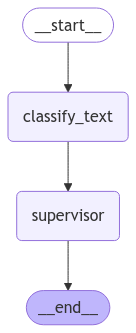

In [107]:
from langgraph.graph import END
from langgraph.graph import StateGraph
from IPython.display import Image, display

# set up the graph
graph_builder = StateGraph(MessagesState)

# add nodes
graph_builder.add_node(classify_text)
graph_builder.add_node(supervisor)

# set the entry point
graph_builder.set_entry_point("classify_text")

# add edges between the nodes
graph_builder.add_edge("classify_text", "supervisor")

# add the endpoint
graph_builder.add_edge("supervisor", END)

# generate the graph
graph = graph_builder.compile()

# we can print out the layout of the graph for visualization purposes
display(Image(graph.get_graph().draw_mermaid_png())) # show our graph architecture

Now, we can pass our text directly to the graph:

In [109]:
graph.invoke({"messages": [("user", uk_media_sample['text'][0])]})


Incorrect classification - classiyfing with supervisor



{'messages': [HumanMessage(content='Sugary drink risk ', additional_kwargs={}, response_metadata={}, id='2c2498a7-f76b-4409-ac17-6fda6dd5d66e'),
  AIMessage(content='2', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-02-26T19:43:46.2227318Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2695798200, 'load_duration': 25451700, 'prompt_eval_count': 1827, 'prompt_eval_duration': 285000000, 'eval_count': 2, 'eval_duration': 2379000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-9decf24d-df2f-4cf9-bf9b-b70e07a7219f-0', usage_metadata={'input_tokens': 1827, 'output_tokens': 2, 'total_tokens': 1829}),
  AIMessage(content='3', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 1824, 'total_tokens': 1826, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'pr

If we want to get a better look what's going on inside the graph, we can stream it. We're utilzing the `HumanMessage` format here, but it is essentially the same as marking the message as "user" with a dictionary. 

We can see the first model, Llama 3.2 marks the text as CAP category 2 (Civil Rights), but the second model, GPT 4o-mini, questions this judgement and classifies it as category 3 (Health).

In [108]:
from langchain_core.messages import HumanMessage

input_message = uk_media_sample['text'][0]

for step in graph.stream(
    #{"messages": [{"role": "user", "content": input_message}]},
    {"messages": [HumanMessage(content=input_message)]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Sugary drink risk 
================================== Ai Message ==================================

2

Incorrect classification - classiyfing with supervisor

================================== Ai Message ==================================

3


In [ ]:
# if we only want the final classifcation, we can access the last message's content

from langchain_core.messages import HumanMessage

input_message = uk_media_sample['text'][0]

output = graph.invoke({"messages": HumanMessage(content=input_message)})

output["messages"][-1].content


Incorrect classification - classiyfing with supervisor



'3'

In [115]:
# we can loop this as well

classification = [graph.invoke({"messages": HumanMessage(content=txt)})["messages"][-1].content for txt in uk_media_sample['text'][0:5]]


Incorrect classification - classiyfing with supervisor


Incorrect classification - classiyfing with supervisor


Incorrect classification - classiyfing with supervisor


Incorrect classification - classiyfing with supervisor


Incorrect classification - classiyfing with supervisor



In [116]:
classification

['3', '19', '2', '2', '15']

This may seem like an arbitrary example, and it is. After all, there are easier ways to check one model's output against the other's. _However_ the Graph structure is powerful in that it allows for interaction between models (including back-and-forth loops) and the implementation of additional tools.

## Retrieval Augmented Generation (RAG)

One of the most common tool uses is so-called Retrieval Augmented Generation (RAG). It allows a model to access a database, find documents that might help answer the question it is facing, and incorporate the content of these documents into its answer. This makes LLMs a lot more reliable when it comes to reporting factual information.

The central building block of RAG systems is the so-called retriever. It is responsible for retrieving relevant documents. When working with text data, it makes use of embedding models to retrieve relevant documents. Note, however, that a retriever can also access an API, such as Wikipedia or Google, to retrieve documents! This makes them very flexible for a large number of tasks.

As a small toy example, we are using a Chroma vector store which I've populated with a bit of scientific literature on the Public Sphere. It contains:
- Barberá, Pablo et al. 2019. Who Leads? Who Follows? Measuring Issue Attention and Agenda Setting by Legislators and the Mass Public Using Social Media Data. American Political Science Review 113: 883–901. https://doi.org/10.1017/S0003055419000352.
- Berg, Sebastian, Niklas Rakowski, und Thorsten Thiel. 2020. Die digitale Konstellation. Eine Positionsbestimmung. Zeitschrift für Politikwissenschaft 30: 171–191. https://doi.org/10.1007/s41358-020-00207-6.
- Dahlberg, Lincoln. 2011. Re-constructing digital democracy: An outline of four ‘positions’. New Media & Society 13: 855–872. https://doi.org/10.1177/1461444810389569.
- Fraser, Nancy. 1990. Rethinking the Public Sphere: A Contribution to the Critique of Actually Existing Democracy. Social Text 56–80. https://doi.org/10.2307/466240.
- Jungherr, Andreas, und Ralph Schroeder. 2021. Digital Transformations of the Public Arena. Cambridge: Cambridge University Press. https://doi.org/10.1017/9781009064484.

If you are interested in building your own Chroma vector store, you can use this code. Note that it assumes that your documents are stored as PDFs. If this is not the case, check out the [LangChain Page on Document Loaders](https://python.langchain.com/docs/integrations/document_loaders/). Shortening the documents into smaller chunks (as done here) is optional, but it often helps retrieving more relevant information. This, however, is dependant on your documents and the task you are trying to accomplish!

Note that turning your documents into a vector store requires an **embedding model**. We can use Ollama to employ one locally. I recommend [Nomic](https://ollama.com/library/nomic-embed-text), as it does a pretty good job at retrieval tasks. But you can change this if needed (or curious). This means Ollama needs to run (serve) in the background when making your vector store.

In [ ]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma


lit_directory = "./my_documents/" # directory with literature to load for the RAG
db_directory = "./data/test_chroma_db" # directory to save the vector store. adjust this accordingly

short_docs = True # shorten document from pages to chunks? (set chunk size below)

embeddings = OllamaEmbeddings(model = "nomic-embed-text")

# load documents
loader = PyPDFDirectoryLoader(lit_directory)
docs = loader.load() # metadata tracks paper and page number; each page is a single document

if short_docs:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,  # chunk size (characters)
        chunk_overlap=200,  # chunk overlap (characters)
        add_start_index=True,  # track index in original document
        )
    docs = text_splitter.split_documents(docs)

# make doc vector store. as the vector store can get quite large (and takes time to initialize in memory), we use a chroma database to store the vectors    
vector_store = Chroma(
    collection_name="test_store", # name of the collection - change to taste
    embedding_function=embeddings,
    persist_directory=db_directory,  # save data locally
    )

vector_store.add_documents(docs) # add docs

You can also connect to the database I've prepared. You also need the Ollama Embeddings here. 

**Important**: As Vector Stores such as Chroma are made with production-level capacities in mind, they are not objects you load into your environment, like a .csv file. Rather, they are a database your Python instance connects with (like a SQL-Database). After connecting to it, you can populate it with more documents (`add_documents()` - see above) or do other things with it, like search it. However, this means that adding more documents directly writes onto the existing database - so be a bit careful about introducing duplicates and the like.

For more information on vector stores, see [here](https://python.langchain.com/docs/concepts/vectorstores/).

In [6]:
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma

db_directory = "./data/test_chroma_db" # directory to save the vector store. adjust this accordingly
embeddings = OllamaEmbeddings(model = "nomic-embed-text")

vector_store = Chroma(
    collection_name="test_store",
    embedding_function=embeddings,
    persist_directory=db_directory,  # save data locally
)

We can run a simple search on our documents now. As this is a _vector_ store, it embeds the documents in a vector space via the chosen embedding model. Hence, we can use familiar methods such as cosine similarity to retrieve documents fitting our search term.

_Note_: A good embedding model such as Nomic can be very powerful for a number of tasks, such as document clustering, or finding topical documents.

In [7]:
vector_store.similarity_search("counter publics")

[Document(id='5c5ebda3-a6f2-4efb-9160-913e7f7807c7', metadata={'author': 'Lincoln Dahlberg', 'creationdate': '2011-08-25T17:18:27+05:30', 'creator': 'Adobe InDesign CS5.5 (7.5)', 'crossmarkdomainexclusive': 'true', 'crossmarkdomains[1]': 'journals.sagepub.com', 'crossmarkmajorversiondate': '2011-02-08', 'doi': '10.1177/1461444810389569', 'keywords': 'autonomist Marxism,counter-publics,deliberative,digital democracy,liberal-individualist', 'moddate': '2020-02-18T22:42:27+01:00', 'page': 6, 'page_label': '7', 'producer': 'Adobe PDF Library 9.9; modified using iText 4.2.0 by 1T3XT', 'source': 'my_documents\\Dahlberg 2011 Re-Constructing Digital Democracy.pdf', 'start_index': 748, 'subject': 'New Media & Society 2011.13:855-872', 'title': 'Re-constructing digital democracy: An outline of four ‘positions’', 'total_pages': 18}, page_content='subsequently can come to ‘publicly’ (second meaning) contest dominant discourses that \nframe hegemonic practices and meanings, including the boundaries

Note that, as we previously split the documents into smaller chunks, only these chunks are returned. Lucky for us, the metadata reports the page number - so we can find the text chunk in our document if we need to.

Now, we can turn our vector store into a retriever. In this case, the retriever is not much more than a wrapper for accessing the vector store. But they provide a unified connection to other parts of our RAG system - even when we are not using a vector store, but an API such as Wikipedia!

In [8]:
# turn the vector store into a retriever

docs_returned = 5 # we can set the number of documents to return in the kwargs below. kwargs are specific to the underlying database!

retriever = vector_store.as_retriever(
    search_type="similarity", # similarity score; optionally with threshold ("similarity_score_threshold" with "score_threshold" kwarg)
    search_kwargs={"k": docs_returned}, # make sure the number of documents passed (k) fits into the context window
    )

Here, the retriever does the same as the vector store. However, note that we passed the argument to return 5 documents, so now we get 5 documents instead of the default 4.

In [9]:
retriever.invoke("counter publics")

[Document(id='5c5ebda3-a6f2-4efb-9160-913e7f7807c7', metadata={'author': 'Lincoln Dahlberg', 'creationdate': '2011-08-25T17:18:27+05:30', 'creator': 'Adobe InDesign CS5.5 (7.5)', 'crossmarkdomainexclusive': 'true', 'crossmarkdomains[1]': 'journals.sagepub.com', 'crossmarkmajorversiondate': '2011-02-08', 'doi': '10.1177/1461444810389569', 'keywords': 'autonomist Marxism,counter-publics,deliberative,digital democracy,liberal-individualist', 'moddate': '2020-02-18T22:42:27+01:00', 'page': 6, 'page_label': '7', 'producer': 'Adobe PDF Library 9.9; modified using iText 4.2.0 by 1T3XT', 'source': 'my_documents\\Dahlberg 2011 Re-Constructing Digital Democracy.pdf', 'start_index': 748, 'subject': 'New Media & Society 2011.13:855-872', 'title': 'Re-constructing digital democracy: An outline of four ‘positions’', 'total_pages': 18}, page_content='subsequently can come to ‘publicly’ (second meaning) contest dominant discourses that \nframe hegemonic practices and meanings, including the boundaries

Next, we turn our retriever into a **_tool_** - something our LLM recognizes as something it can use, and uses it accordingly.

**Important**: Not all models support tool use. When searching for [Ollama models](https://ollama.com/search), look for the `tools` tag. If tool use is not supported you can stil build a RAG system by always providing the model with the results of your vector store search (e.g. by simply passing the question to your vector store or retriever). Note however, that only with proper tool use, the agent can autonomously decide when to use the RAG functionality.

What happens in this code chunk is that we set up a simple function that invokes the retriever, and passes the results into a single string (serializes them). Two things are important: 1) the `@tool` decorator marks the function as a tool, and b) the function description marked by `""" """` (that would usually be part of the documentation) is visible to the model and helps it decide when and how to use the tool. Before we can use the tool in our graph, we need to turn it into a `ToolNode`.

In [ ]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def retrieve(query: str):
    # note that the function name and the doc string of the tool are provided to the model, thus should be descriptive
    """Search and return relevant text passages from scientific literature that can be used to answer the question."""
    retrieved_docs = retriever.invoke(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# build retrieval tool as tool node (receives an AI message from query_or_respond)
tools = ToolNode([retrieve])

Next, we set up our LLM, and write two functions. One that prompts the model to decide whether or not to use the tool, and one that generates an answer to our question. If our retriever has been used previously, we can access its output through the tool message it returned. Generally note how communication between the parts of our system - as previously - is happening via the `MessagesState`.

If you are interested what's happening in detail, I recommend this [tutorial by LangChain](https://python.langchain.com/docs/tutorials/qa_chat_history/).

**Important**: As the decision to use our retriever is done by a differnt node than the actual generation, we _can_ use different models for each step. For example, we could use a model that's good at reasoning (and supports tool use) to decide whether or not to retrieve, and a cheaper model good at generating text on the generation node.

In [ ]:
from langchain_core.messages import SystemMessage
from dotenv import load_dotenv # to load .env file
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState 


load_dotenv()
# note that ChatOpenAI fetches your API key from your environment - you only need to load the .env file

# for now, we'll use GPT 4o-mini for both tasks
textgen_llm = ChatOpenAI(model = "gpt-4o-mini-2024-07-18",
                        temperature=0.0,
                        )

# we can use different models for different tasks, e.g. a more expensive model for reasoning (should documents be retrieved?) and a cheaper model for text generation
reasoning_llm = ChatOpenAI(model = "gpt-4o-mini-2024-07-18",
                        temperature=0.0,
                        )



system_prompt = (
  "You are a helpful assistant for finding relevant text passages in scientific literature."
   "Use the following pieces of retrieved context to answer the question."
   "If you don't know the answer, just say that you don't know, don't try to make up an answer."
)


# agent to decide whether or not to use tools
def query_or_respond(state: MessagesState):
        """Generate tool call for retrieval or respond directly."""
        llm_with_tools = reasoning_llm.bind_tools([retrieve])
        response = llm_with_tools.invoke(state["messages"])
        # MessagesState appends messages to state instead of overwriting
        return {"messages": [response]}

# Generate a response
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages (that is, our retrieved documents)
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt by first adding the retrieved documents to the system prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = f"{system_prompt}\n\n{docs_content}"
    
    # ... then adding the rest of the conversation - including the user question
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = textgen_llm.invoke(prompt)
    return {"messages": [response]}

Now, we set up our graph as before, and plot it to better see what's going on:

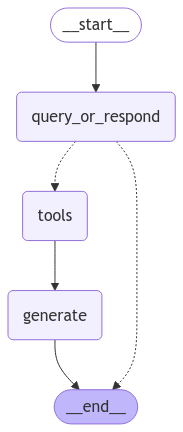

In [16]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph
from IPython.display import Image, display

graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

As we can see, our agent system will:
1. Receive a user query
2. Decide whether to query a tool call to our RAG system or to respond directly
3. If the system decides to make a tool call:
    1. it **autonomously formulates a search query** and calls the retriever
    2. The retriever's output is added to the system prompt, and an answer to question is generated

Let's see it in action!

In [17]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


Note that the system decided to not call the retriever, but instead generated a generic response immediately.

In [18]:
input_message = "What are counter publics?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What are counter publics?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_KKPr6kWJ1L4GaesiwswKoxM3)
 Call ID: call_KKPr6kWJ1L4GaesiwswKoxM3
  Args:
    query: counter publics definition
================================= Tool Message =================================
Name: retrieve

("Source: {'author': 'Lincoln Dahlberg', 'creationdate': '2011-08-25T17:18:27+05:30', 'creator': 'Adobe InDesign CS5.5 (7.5)', 'crossmarkdomainexclusive': 'true', 'crossmarkdomains[1]': 'journals.sagepub.com', 'crossmarkmajorversiondate': '2011-02-08', 'doi': '10.1177/1461444810389569', 'keywords': 'autonomist Marxism,counter-publics,deliberative,digital democracy,liberal-individualist', 'moddate': '2020-02-18T22:42:27+01:00', 'page': 6, 'page_label': '7', 'producer': 'Adobe PDF Library 9.9; modified using iText 4.2.0 by 1T3XT', 'source': 'my_documents\\\\Dahlberg 20

Here, the system autonomously queried the retriever with `counter publics definition`, then used the content to provide an answer. It even returned the source!

## Other Tools

Note that apart from RAG, there are various other tools you can employ. Basically, any python function can be a tool when employed in the LangGraph framework - from simple calculations, to API calls, to plotting, even a BERT-based classifier.

**_The strength of agentic systems is not that any one LLM can do everything, but that they can decide when to use a tool that accomplishes a given task._**

If you are interested in setting up more tools and agentic systems, I recommend the [LangChain](https://python.langchain.com/docs/tutorials/#orchestration) and [LangGraph](https://langchain-ai.github.io/langgraph/how-tos/) tutorial pages.